In [1]:
%load_ext Cython
import cProfile
import pandas as pd
import numpy as np
import re
import geopandas as gpd
import matplotlib.pyplot as plt
from geopandas import GeoDataFrame
from shapely.geometry import Point

df = pd.read_csv('destination_demand.csv', index_col = 'Unnamed: 0')

In [2]:
def average_difference(month,year,dayofweek,hr,df):
    community_areas  = np.zeros(77)
    df = df.dropna()
    df = df[(df['month'] == month) & (df['year'] == year) & (df['dayofweek'] == dayofweek) & (df['hour'] == hr+1)]
    missing_ca = [i for i in range(1,78) if i not in df['dropoff_community_area'].values]
        
    for i in missing_ca:
        df = df.append(pd.Series([0,month, year, dayofweek,hr,i], index=df.columns), ignore_index=True)
        
    for i in df['dropoff_community_area'].values:
        diff_sum = 0
        record = df[df['dropoff_community_area'] == i]
        
        for j in df['dropoff_community_area'].values:
            diff_sum += record['count(1)'].values[0] - df[df['dropoff_community_area'] == j]['count(1)'].values[0] 
        
        community_areas[int(i-1)] = diff_sum/77
        
    return community_areas
        

In [3]:
def twentyfourhr(month,year,dayofweek,df):
    day = np.zeros((24,77))
    for hr in range(0,24): 
        day[hr] = average_difference(month,year,dayofweek,hr,df) 
    return day

In [4]:
cProfile.run('twentyfourhr(3,2017,4,df)')

         197343116 function calls (195309844 primitive calls) in 278.733 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   288892    0.438    0.000    0.647    0.000 <frozen importlib._bootstrap>:416(parent)
  1742316    0.974    0.000    3.496    0.000 <frozen importlib._bootstrap>:997(_handle_fromlist)
       24    4.037    0.168  278.731   11.614 <ipython-input-2-9cdd58ad9b5e>:1(average_difference)
       24    0.029    0.001    0.055    0.002 <ipython-input-2-9cdd58ad9b5e>:5(<listcomp>)
        1    0.001    0.001  278.733  278.733 <ipython-input-3-5917fe2e3c18>:1(twentyfourhr)
        1    0.000    0.000  278.733  278.733 <string>:1(<module>)
   146248    0.254    0.000    0.408    0.000 __init__.py:221(iteritems)
       24    0.000    0.000    0.000    0.000 __init__.py:227(itervalues)
        3    0.000    0.000    0.000    0.000 _collections_abc.py:252(__subclasshook__)
        2    0.000    0.000    0.000    0.000

      508    0.007    0.000    0.150    0.000 concat.py:486(_concat_index_asobject)
      508    0.001    0.000    0.006    0.000 concat.py:496(<listcomp>)
      508    0.002    0.000    0.002    0.000 concat.py:503(<listcomp>)
      508    0.001    0.000    0.001    0.000 concat.py:507(<listcomp>)
     1524    0.001    0.000    0.004    0.000 concat.py:510(<genexpr>)
      508    0.004    0.000    0.024    0.000 concat.py:84(_get_frame_result_type)
     1016    0.001    0.000    0.007    0.000 concat.py:92(<genexpr>)
     1016    0.001    0.000    0.008    0.000 concat.py:93(<genexpr>)
     1016    0.001    0.000    0.004    0.000 concat.py:97(<genexpr>)
      532    0.008    0.000    0.210    0.000 construction.py:106(init_ndarray)
      532    0.002    0.000    0.003    0.000 construction.py:217(prep_ndarray)
      532    0.002    0.000    0.021    0.000 construction.py:363(_get_axes)
   144868    1.696    0.000   20.115    0.000 construction.py:537(sanitize_array)
   144360    1.04

       24    0.000    0.000    0.000    0.000 shape_base.py:283(<listcomp>)
       48    0.000    0.000    0.000    0.000 shape_base.py:83(atleast_2d)
   144312    0.242    0.000    0.401    0.000 sparse.py:196(construct_from_string)
       68    0.000    0.000    0.000    0.000 typing.py:1019(_abc_negative_cache)
       43    0.000    0.000    0.000    0.000 typing.py:1033(_abc_negative_cache_version)
       75    0.000    0.000    0.000    0.000 typing.py:1089(__eq__)
   135/35    0.000    0.000    0.002    0.000 typing.py:1145(__subclasscheck__)
    17/16    0.000    0.000    0.001    0.000 typing.py:875(__extrahook__)
        8    0.000    0.000    0.000    0.000 typing.py:889(__extrahook__)
   146248    0.108    0.000    0.108    0.000 {built-in method __new__ of type object at 0x10c348dd8}
       72    0.012    0.000    0.012    0.000 {built-in method _operator.and_}
       24    0.088    0.004    0.088    0.004 {built-in method _operator.inv}
5248/4740    0.008    0.000    0.087

In [5]:
%%cython
import numpy as np
cimport numpy as np
import pandas as pd

def average_difference_opt(month,year,dayofweek,hr,df):
    community_areas  = np.zeros(77)
    df = df.dropna()
    df = df[(df['month'] == month) & (df['year'] == year) & (df['dayofweek'] == dayofweek) & (df['hour'] == hr+1)]
    missing_ca = [i for i in range(1,78) if i not in df['dropoff_community_area'].values]
        
    for i in missing_ca:
        df = df.append(pd.Series([0,month, year, dayofweek,hr,i], index=df.columns), ignore_index=True)
        
    for i in df['dropoff_community_area'].values:
        diff_sum = 0
        record = df[df['dropoff_community_area'] == i]
        
        for j in df['dropoff_community_area'].values:
            diff_sum += record['count(1)'].values[0] - df[df['dropoff_community_area'] == j]['count(1)'].values[0] 
        
        community_areas[int(i-1)] = diff_sum/77
        
    return community_areas

In [6]:
def twentyfourhr_opt(month,year,dayofweek,df):
    day = np.zeros((24,77))
    for hr in range(0,24): 
        day[hr] = average_difference_opt(month,year,dayofweek,hr,df) 
    return day

In [7]:
cProfile.run('twentyfourhr_opt(3,2017,4,df)')

         197340726 function calls (195308214 primitive calls) in 256.224 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   288892    0.409    0.000    0.611    0.000 <frozen importlib._bootstrap>:416(parent)
  1742316    0.907    0.000    3.278    0.000 <frozen importlib._bootstrap>:997(_handle_fromlist)
        1    0.000    0.000  256.224  256.224 <ipython-input-6-5e1c3284cb3a>:1(twentyfourhr_opt)
        1    0.000    0.000  256.224  256.224 <string>:1(<module>)
   146248    0.256    0.000    0.398    0.000 __init__.py:221(iteritems)
       24    0.000    0.000    0.000    0.000 __init__.py:227(itervalues)
  1157429    3.483    0.000    9.327    0.000 _dtype.py:319(_name_get)
   290488    1.187    0.000    3.176    0.000 _dtype.py:46(__str__)
      508    0.002    0.000    0.002    0.000 _internal.py:886(npy_ctypes_check)
       48    0.000    0.000    0.684    0.014 _methods.py:34(_sum)
   722556    0.518    0.000    4

   576720    4.219    0.000  159.075    0.000 frame.py:2893(__getitem__)
   144168    1.352    0.000  132.197    0.001 frame.py:2952(_getitem_bool_array)
   144288    0.595    0.000    6.271    0.000 frame.py:3342(_box_item_values)
   144288    0.502    0.000    4.302    0.000 frame.py:3349(_box_col_values)
   144772    0.105    0.000    0.105    0.000 frame.py:361(_constructor)
   145764    0.994    0.000    2.144    0.000 frame.py:378(__init__)
       24    0.014    0.001    3.473    0.145 frame.py:4456(dropna)
     1016    0.002    0.000    0.007    0.000 frame.py:491(shape)
      508    0.021    0.000    1.554    0.003 frame.py:6558(append)
       24    0.025    0.001    2.860    0.119 frame.py:7240(count)
       24    0.001    0.000    2.508    0.104 frame.py:7384(_reduce)
       24    0.000    0.000    2.495    0.104 frame.py:7395(f)
       24    0.000    0.000    0.000    0.000 frame.py:7600(_get_agg_axis)
       24    0.000    0.000    0.003    0.000 fromnumeric.py:2083(any)
  

   146756    0.240    0.000    0.722    0.000 {built-in method builtins.sum}
   290536    0.820    0.000    0.820    0.000 {built-in method numpy.arange}
1592231/1303847    4.531    0.000   12.750    0.000 {built-in method numpy.array}
     1572    0.042    0.000    0.042    0.000 {built-in method numpy.concatenate}
   580468    1.538    0.000    1.538    0.000 {built-in method numpy.empty}
  1154400    0.353    0.000    0.353    0.000 {built-in method numpy.geterrobj}
       24    0.345    0.014    0.345    0.014 {built-in method numpy.putmask}
   577200    0.603    0.000    0.603    0.000 {built-in method numpy.seterrobj}
        1    0.000    0.000    0.000    0.000 {built-in method numpy.zeros}
   288552    0.320    0.000    0.320    0.000 {built-in method pandas._libs.missing.checknull}
     4064    0.001    0.000    0.001    0.000 {method 'add' of 'set' objects}
      508    0.001    0.000    0.008    0.000 {method 'all' of 'numpy.ndarray' objects}
   722556    0.808    0.000    

In [8]:
avg_diff = twentyfourhr(3,2017,4,df)

In [9]:
cahp = gpd.read_file('./Boundaries - Community Areas (current)/geo_export_a30146d3-7df1-499d-84f7-c7fef58a4030.shp')
geo_df = pd.DataFrame(cahp)
geo_df['area_num_1'] = geo_df['area_num_1'].astype(float)

In [10]:
for i in range(0,24): 
    hr = pd.DataFrame({str(i+1) + 'hr' : avg_diff[i,:]})
    hr['community_area'] = hr.index.values + 1
    geo_df = pd.merge(hr,geo_df, left_on = 'community_area', right_on = 'area_num_1')
    geo_df.drop('community_area', inplace=True, axis=1)

In [11]:
columns = ['area','comarea','comarea_id','perimeter']
geo_df.drop(columns, inplace=True, axis=1)

max_val = max([geo_df.loc[geo_df[str(i)+'hr'].idxmax()][str(i)+'hr'] for i in range(1,25)])
min_val = min([geo_df.loc[geo_df[str(i)+'hr'].idxmin()][str(i)+'hr'] for i in range(1,25)])

In [12]:
crs = {'init': 'epsg:4326'}
gdf = GeoDataFrame(geo_df, crs=crs, geometry=geo_df.geometry)

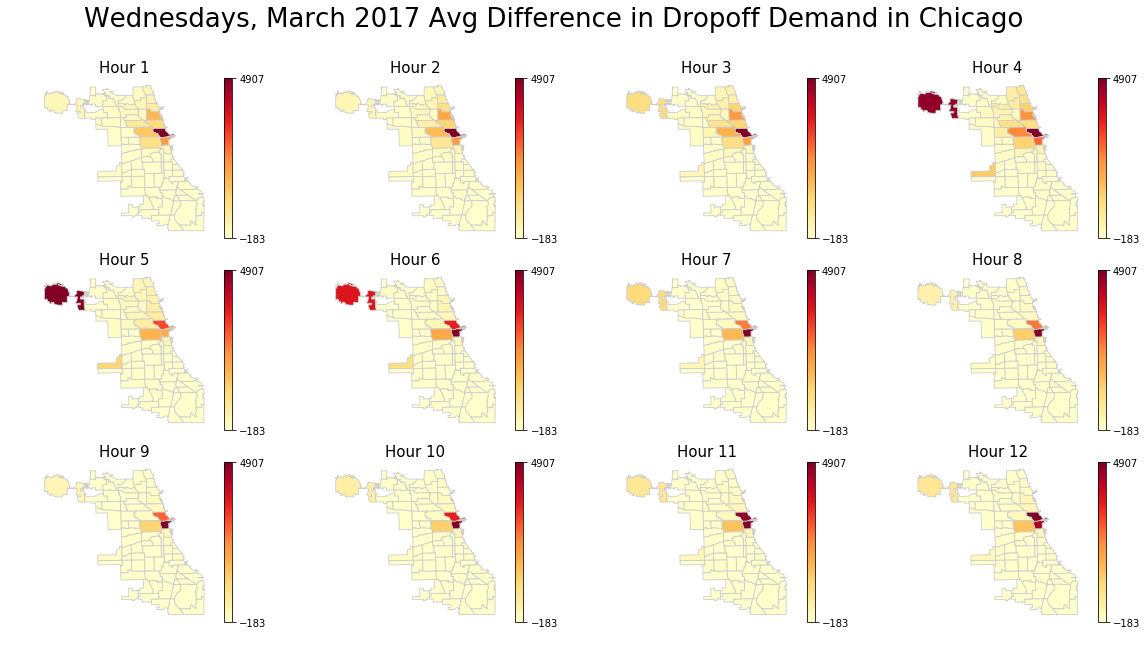

In [17]:
# create figure and axes for Matplotlib
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(20, 10))
counter = 1
for row in range(0,3):
    for item in range(0,4):
        gdf.plot(column=str(counter)+'hr', cmap='YlOrRd', linewidth=0.8, edgecolor='0.8', ax = ax.flat[counter-1])
        # set the range for the choropleth
        vmin, vmax = min_val, max_val
        ax[row,item].axis('off')
        ax[row, item].set_title('Hour '+str(counter),fontsize=15)
        # Create colorbar as a legend
        sm = plt.cm.ScalarMappable(cmap='YlOrRd', norm=plt.Normalize(vmin=vmin, vmax=vmax))
        # empty array for the data range
        sm._A = []
        # add the colorbar to the figure
        cbar = fig.colorbar(sm,ax=ax[row,item],ticks=[vmin, vmax])
        counter += 1

fig.suptitle("Wednesdays, March 2017 Avg Difference in Dropoff Demand in Chicago ",fontsize=26)
plt.show()


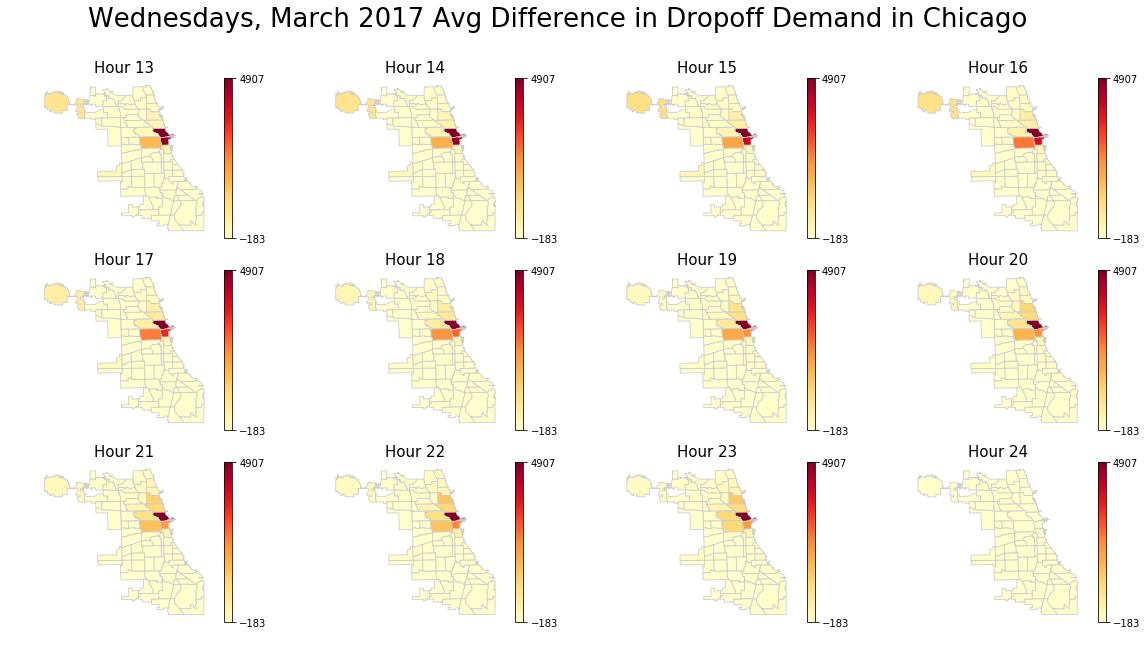

In [18]:
# create figure and axes for Matplotlib
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(20, 10))

for row in range(0,3):
    for item in range(0,4):
        gdf.plot(column=str(counter)+'hr', cmap='YlOrRd', linewidth=0.8, edgecolor='0.8', ax = ax.flat[counter-13])
        # set the range for the choropleth
        vmin, vmax = min_val, max_val
        ax[row,item].axis('off')
        ax[row, item].set_title('Hour '+str(counter),fontsize=15)
        # Create colorbar as a legend
        sm = plt.cm.ScalarMappable(cmap='YlOrRd', norm=plt.Normalize(vmin=vmin, vmax=vmax))
        # empty array for the data range
        sm._A = []
        # add the colorbar to the figure
        cbar = fig.colorbar(sm,ax=ax[row,item],ticks=[vmin, vmax])
        counter += 1

fig.suptitle("Wednesdays, March 2017 Avg Difference in Dropoff Demand in Chicago",fontsize=26)
plt.show()